## SSAC - Exploration 12 - DC GAN : cifar 10

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


---
### STEP 1. 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, train_y), (test_x, test_y) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)


    학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
    로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
    tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.


In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


---
#### 로드 데이터 시각화

In [5]:
train_x.shape

(50000, 32, 32, 3)

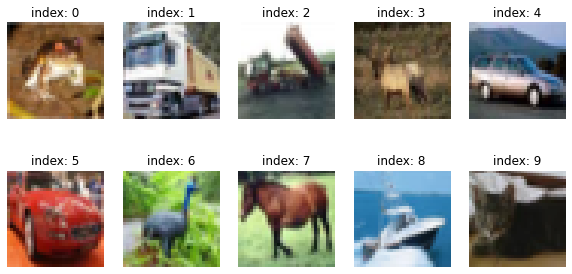

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    sample = (train_x[i]+1)/2
    plt.imshow(sample.reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

---
#### 미니배치 데이터 셋 구성

In [5]:
# 텐서플로우 dataset으로 준비하기
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

---
### STEP 2. 생성자 모델 구현하기

---
#### 생성자 모델 구현 함수 작성

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

---
#### 노이즈를 넣어 랜덤 이미지 생성해 보기

In [11]:
# 샘플 노이즈 벡터 만들기
noise = tf.random.normal([1, 100])

In [12]:
# 작동 확인
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

+ 생성된 이미지의 크기는 cifar10 데이터와 동일한 32,32 사이즈의 3채널 이미지 인 것을 확인할 수 있다.

In [13]:
generated_image = (generated_image + 1) / 2.0

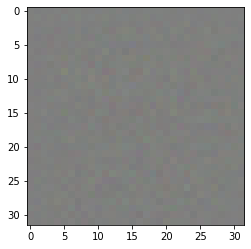

In [14]:
plt.imshow(generated_image[0])
plt.show()

+ 회색 노이즈 이미지가 생성된 것을 확인할 수 있다.

---
### STEP 3. 판별자 모델 구현하기

---
### 판별자 모델 구현함수

In [12]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
# 판별모델 생성
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [17]:
# 아까 만든 이미지를 주었을 때 결과 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01456966]], dtype=float32)>

---
### STEP 4. 손실함수와 최적화 함수 구현하기

---
#### 생성자와 편발자의 손실함수 구현

In [18]:
# 손실함수 받아오기
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [104]:
# generator loss 구현하기 만들어낸 이미지의 판별자 출력값과 그 출력값과 동일한 사이즈의 모든 원소가 1인 데이터 와의 비교
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [105]:
# discriminator loss 구현하기 : 만들어낸 이미지 출력값은 0과, 진짜 이미지 출력값은 1과 비교
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

---
#### 이미지 판별 정확도 계산 함수 구현

In [21]:
# 진짜를 진짜로 판별한 정확도와 가짜를 가짜로 판별한 정확도 계산 : 이상적인 결과는 둘 다 0.5에 가까워 지는 것.
# 판별을 잘해서 가짜 판별 정확도가 1.0에 가까우면 생성자가 판별자를 잘 속이지 못하는 것
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

---
### 생성자, 판별자 최적화 함수 정의

In [22]:
# 생성 판별 최적화는 adam 사용 : 두 모델 따로 학습하므로 최적화를 따로 만들어줘야 한다
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

---
### STEP 5. 훈련과정 상세 기능 구현하기

---
### train_step() 함수

In [37]:
# 데코레이터 사용된 함수에 입력된 입력은 tf의 graph 노드가 될수 있는 타입으로 자동 변환됨

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

---
#### 16개 seed 입력으로 훈련 과정 중에 생성한 이미지 시각화 하는 함수 구현

In [24]:
# 매번 학습이 어떻게 진행되어가는지 보기 위해 생성자 생성 샘플을 16장씩 뽑아 확인하기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [25]:
# 학습 현황을 볼 수 있는 함수 : 고정한 seed의 결과물이 어떻게 되는지 확인할 수 있다.
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        sample = (predictions[i]+1)/2
        plt.imshow(sample)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

---
#### 훈련 epoch마다 생성자 판별자의 loss, 생성자 판별자의 accuracy를 그래프로 시각화 하는 함수 구현

In [26]:
# 학습 과정 중 loss history 볼 수 있는 함수
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

---
#### checkpoint 모듈 생성

In [27]:
# 체크포인트 만들기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "cp")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---
### STEP 6. 학습 과정 진행하기

In [28]:
# 만든것 합치기
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [29]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

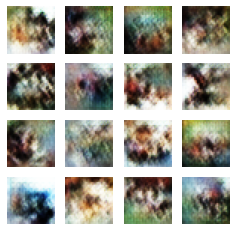

Time for training : 1780 sec


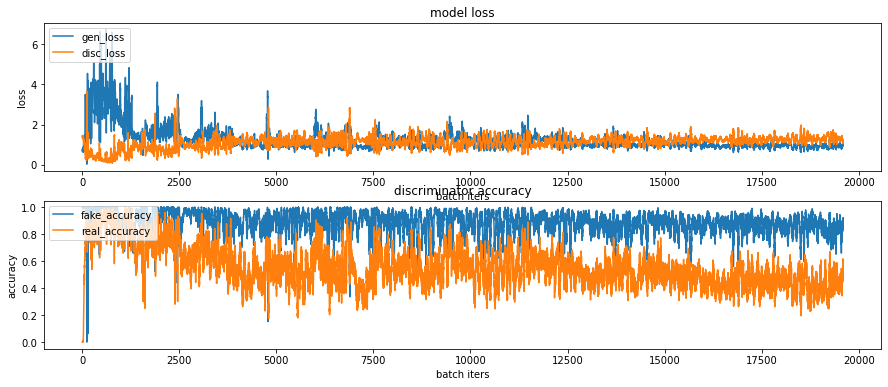

In [30]:
# 학습시작
train(train_dataset, EPOCHS, save_every)

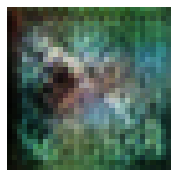

In [60]:
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5 
np_generated = np_generated.astype(int)
plt.figure(figsize=(3, 3))
plt.imshow(np_generated[0])
plt.axis('off')

plt.show()

In [61]:
# 만든 이미지를 판별자에게 주었을 때 결과 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.2590421]], dtype=float32)>

+ 뭔지 알 수 없는 이미지를 만들었고 판별자의 판단에도 완전한 가짜 이미지가 생성 되었다.

tf.Tensor([[1.1408736]], shape=(1, 1), dtype=float32)


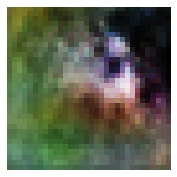

In [43]:
status = True
while status:
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    decision = discriminator(generated_image, training=False)
    if decision >= 0.5:
        status = False
np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5  
np_generated = np_generated.astype(int)
plt.figure(figsize=(3, 3))
plt.imshow(np_generated[0])
plt.axis('off')
print(decision)
plt.show()  

+ 판별자의 판별을 통과하는 이미지를 생성하게 해 보았는데 동물 얼굴 같기도 한 이미지가 생성 되었다.
+ cifar 10에 있는 사진은 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭 인데 그중에서는 개 얼굴이 그나마 닮지 않았나 싶

In [73]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

#### 생성 이미지 
![cifar10gif](https://github.com/attagungho/ssac_repo/blob/main/exploration/12_dc_gan/images/cifar10_dcgan_1.gif)

#### 훈련 경과에 따른 accuracy 변화
![accuracygraph](https://github.com/attagungho/ssac_repo/blob/main/exploration/12_dc_gan/images/train_history_dcgan_1.png)

+ 100 epoch 학습 후 accuracy 변화를 보면 학습이 계속될 수록 fake accuracy가 조금씩이나마 감소하고 있는 것으로 보인다. 

---
### STEP 7. (optional) GAN 훈련 과정 개선하기

---
#### one-sided smooth labelling

+ 진짜 이미지의 라벨을 1이 아닌 0.9와 같은 약간 작은 값으로 대체하면 gan 학습에 도움이 될 수 있다고 한다. 왜 그런지는 좀 더 공부해 봐야 겠다. 일단 돌려보겠다.

In [95]:
tf.ones_like(decision)-0.1

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9]], dtype=float32)>

In [7]:
# 손실함수 받아오기
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
# generator loss 구현하기 만들어낸 이미지의 판별자 출력값과 그 출력값과 동일한 사이즈의 모든 원소가 1인 데이터 와의 비교
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output)-0.1, fake_output)

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)-0.1, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [30]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)      

In [31]:
# 판별모델 생성
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [32]:
# 진짜를 진짜로 판별한 정확도와 가짜를 가짜로 판별한 정확도 계산 : 이상적인 결과는 둘 다 0.5에 가까워 지는 것.
# 판별을 잘해서 가짜 판별 정확도가 1.0에 가까우면 생성자가 판별자를 잘 속이지 못하는 것
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [33]:
# 생성 판별 최적화는 adam 사용 : 두 모델 따로 학습하므로 최적화를 따로 만들어줘야 한다
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
# 체크포인트 만들기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "cpsm")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
EPOCHS = 100
save_every = 5

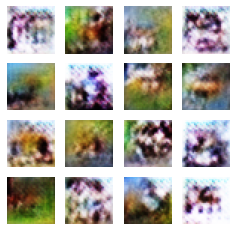

Time for training : 1720 sec


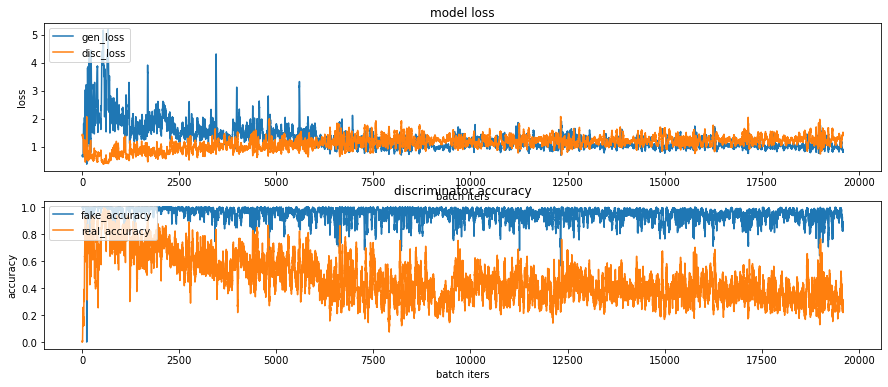

In [38]:
# 학습시작
train(train_dataset, EPOCHS, save_every)

+ 모듬 사진 상으로는 smooth labelling 보다 좋아 보이는데 accuracy 그래프에서 눈에 띄는 개선 점은 없는 것 같다.

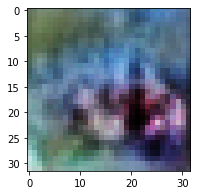

In [41]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5 
np_generated = np_generated.astype(int)

plt.figure(figsize=(3, 3))
plt.imshow(np_generated[0])

plt.show() 

In [42]:
# 만든 이미지를 판별자에게 주었을 때 결과 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.3349961]], dtype=float32)>

tf.Tensor([[0.5662732]], shape=(1, 1), dtype=float32)


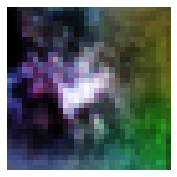

In [44]:
status = True
while status:
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    decision = discriminator(generated_image, training=False)
    if decision >= 0.5:
        status = False
np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5  
np_generated = np_generated.astype(int)
plt.figure(figsize=(3, 3))
plt.imshow(np_generated[0])
plt.axis('off')
print(decision)
plt.show()  

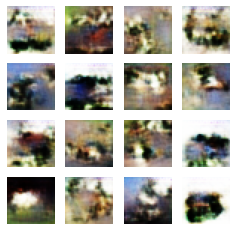

Time for training : 1709 sec


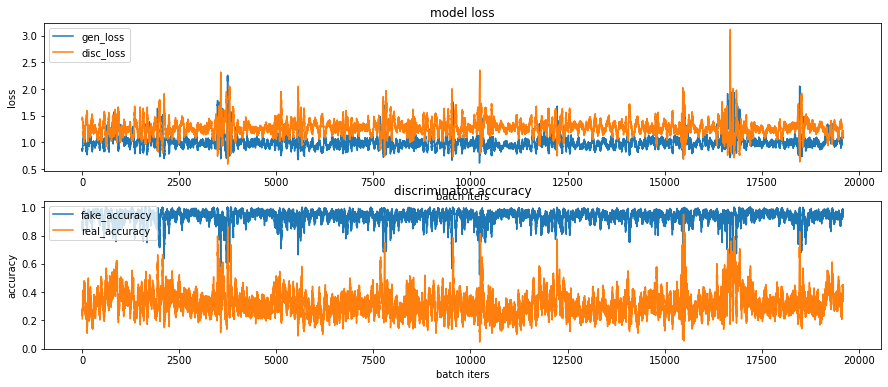

In [45]:
# 학습시작
train(train_dataset, EPOCHS, save_every)

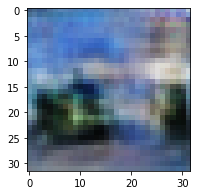

In [46]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5 
np_generated = np_generated.astype(int)

plt.figure(figsize=(3, 3))
plt.imshow(np_generated[0])

plt.show() 

In [47]:
# 만든 이미지를 판별자에게 주었을 때 결과 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.92952]], dtype=float32)>

+ 야채 같아 보이는 사진이 나왔는데 판별기에선 점수가 좋지 못하다

In [50]:
def pick_good_one():
    status = True
    while status:
        noise = tf.random.normal([1, 100])
        generated_image = generator(noise, training=False)
        decision = discriminator(generated_image, training=False)
        if decision >= 0.5:
            status = False
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5  
    np_generated = np_generated.astype(int)
    plt.figure(figsize=(3, 3))
    plt.imshow(np_generated[0])
    plt.axis('off')
    print(decision)
    plt.show()  

tf.Tensor([[0.5265493]], shape=(1, 1), dtype=float32)


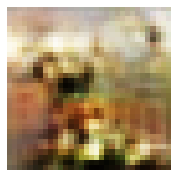

In [52]:
pick_good_one()

+ 인형 같아 보이는 사진이 나오기는 했는데 cifa10 class에는 없는 사진이라 제대로 학습되었는지 판단이 어렵다. 그래프 상으로도 눈에 띄는 개선점은 없는 것 같다. 다만 loss 가 급격히 증가했을 때 오히려 real 과 fake의 accuracy가 교차하는 지점이 있었으며, 이는 loss 만으로 모델이 잘 학습 되었는지 판단이 어렵다는 뜻일 수도 있겠다는 생각이 든다.
+ 만들어진 이미지로 보기에는 적게 학습했을 때나 smooth labelling 하기 전보다 만족 스러운 결과물이 나온 것 같다. 좀더 학습을 진행함에 따라 더 좋은 결과물이 나올 수도 있겠다는 기대는 들지만 연유를 명확히 설명하기 어려워 추가적으로 학습시키지는 않는다.
+ 이 외에도 noisy labelling, ac gan, semi-supervised gan, spectral normalization 등의 방법이 dc gan의 안정적인 학습에 도움이 된다고 한다. 
   + noisy labelling은 학습에 도움이 되는지에 상이한 의견이 있어 그 근거를 추가적으로 궁부한 후 시도해 보는 것이 좋겠다.
   + ac gan, semi-supervised gan은 전반적인 모양에 대해서는 무엇이 다른지 알겠지만 코드 구현에 부족함이 있어 공부를 더 해야 할 것 같다.
   + spectral normalization은 무슨 개념인지 어떤 점에서 도움이 될 수 있는지에 대해 좀 더 공부를 해야 겠다.
+ gan의 학습이 잘 되게 하기가 어렵다고 하는데 저해상도 이미지도 만들기 어려운 것에서 너무 잘 느껴진다.